# Atmospheric composition distribution by CAMS and TROPOMI

### Main goal:
* Compare TROPOMI and CAMS datasets for NO<sub>2</sub>, CO, O<sub>3</sub> and SO<sub>2</sub> (Level 2).

## Imports and supporting functions

In [1]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display

In [46]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_tropomi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

## 1. Define datasets

In [4]:
# Define component
component_nom = 'NO2'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Define sensor
sensor = 'tropomi'
sensor_type = 'L2'
apply_kernels = False

# Define search period
start_date = '2021-11-21'
end_date = '2021-11-21'

# Define extent
lon_min = 12
lon_max = 18.9
lat_min = 48.5
lat_max = 51.1

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In days: [('2021-11-21T00:00:00Z', '2021-11-21T23:00:00Z')]
SEARCH BOUNDING BOX
Latitudes: from 48.5 to 51.1
Longitudes: from 12 to 18.9


## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, 
                                               component_nom, model_full_name, model_level = 'Multiple')

The file exists, it will not be downloaded again.


In [8]:
model_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 8, longitude: 18, step: 8, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-21
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 3.766e-09 ....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-01T16:02 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [9]:
model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/kg to molecules/cm<sup>2</sup>)

In [10]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, component, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels)

The model component units have been converted from kg kg**-1 to kg m**-2.
The model component units have been converted from kg m**-2 to molec cm-2.


### Download read and subset original total columns data

In [11]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')
model_total_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_total_ds = subset(model_total_ds, bbox)
model_total_ds

2021-12-01 16:02:23,224 INFO Welcome to the CDS
2021-12-01 16:02:23,224 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2021-12-01 16:02:23,239 INFO Request is queued


The file does not exist, it will be downloaded.


2021-12-01 16:02:24,247 INFO Request is running
2021-12-01 16:02:28,015 INFO Request is completed
2021-12-01 16:02:28,016 INFO Downloading https://download-0001.copernicus-atmosphere.eu/cache-compute-0001/cache/data3/adaptor.mars_constrained.internal-1638374547.4584007-19738-16-a8dd9c2c-e8c3-4f3f-a481-94b4cef2930e.grib to /home/alba/adc-toolbox/data/cams/NO2/NO2-hourly-tc-2021-11-21-2021-11-21.grib (9.3M)
2021-12-01 16:02:28,199 INFO Download rate 51M/s


<xarray.Dataset>
Dimensions:     (latitude: 8, longitude: 18, step: 8, time: 1)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-11-21
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 ...
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 5.492e-06 ... 8.016...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-01T16:02 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS total columns data units (kg/m2 to molecules/cm<sup>2</sup>)

In [12]:
model_total_ds, _ = model_convert_units(model, model_total_ds, sensor,
                                        component_mol_weight, component, model_levels_df,
                                        start_date, end_date, component_nom, apply_kernels)

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

### Download and read data as xarray

In [13]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, bbox, product_type)

RESULTS
For ('2021-11-21T00:00:00Z', '2021-11-21T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-12-01 16:02:29,184 INFO Found 1 products


Number 0-S5P_NRTI_L2__NO2____20211121T113250_20211121T113750_21282_02_020301_20211121T124029
SELECTED
File name: a55a74f2-61e2-496a-b4ab-c38be3750212
Product name: S5P_NRTI_L2__NO2____20211121T113250_20211121T113750_21282_02_020301_20211121T124029.nc
The file exists, it will not be downloaded again.


In [14]:
sensor_ds, support_input_ds, support_details_ds = sensor_read(sensor, sensor_type, sensor_column, 
                                                              component_nom, dates)
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 372, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [15]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.


<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 372, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float64 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

## 4. Match data (and apply averaging kernels)

In [16]:
match_table = generate_match_table(sensor_ds, model_ds, bbox,  
                                   sensor, component_nom, apply_kernels)
match_table

FOR EST. TIME: 2021-11-21T00:00:00.000000000
The partial columns will be sumed up.
The sum will be matched to the sensor data by nearest neighbours.


delta_time   latitude  \
scanline ground_pixel time       layer                                      
110.0    104.0        2021-11-21 0.0   2021-11-21 11:34:17.633  46.972496   
         105.0        2021-11-21 0.0   2021-11-21 11:34:17.633  46.993160   
         106.0        2021-11-21 0.0   2021-11-21 11:34:17.633  47.013618   
         107.0        2021-11-21 0.0   2021-11-21 11:34:17.633  47.033867   
         108.0        2021-11-21 0.0   2021-11-21 11:34:17.633  47.053917   
...                                                        ...        ...   
188.0    237.0        2021-11-21 33.0  2021-11-21 11:35:23.152  52.451687   
         238.0        2021-11-21 33.0  2021-11-21 11:35:23.152  52.460556   
         239.0        2021-11-21 33.0  2021-11-21 11:35:23.152  52.469383   
         240.0        2021-11-21 33.0  2021-11-21 11:35:23.152  52.478168   
         241.0        2021-11-21 33.0  2021-11-21 11:35:23.152  52.486916   

                                        longitude  qa_value  sensor_column  \
scanline ground_pixel time       layer                                       
110.0    104.0        2021-11-21 0.0    12.900784      0.73   1.457204e+15   
         105.0        2021-11-21 0.0    12.963565      0.88   3.503702e+14   
         106.0        2021-11-21 0.0    13.025986      0.88   2.442857e+14   
         107.0        2021-11-21 0.0    13.088056      0.88   7.331299e+14   
         108.0        2021-11-21 0.0    13.149780      0.88   1.339592e+15   
...                                           ...       ...            ...   
188.0    237.0        2021-11-21 33.0   18.022715      0.74   7.914884e+15   
         238.0        2021-11-21 33.0   18.074289      0.74   8.164915e+15   
         239.0        2021-11-21 33.0   18.125925      0.74   8.434427e+15   
         240.0        2021-11-21 33.0   18.177626      0.74   6.682406e+15   
         241.0        2021-11-21 33.0   18.229391      0.74   7.859993e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
scanline ground_pixel time       layer                                                  
110.0    104.0        2021-11-21 0.0                                         0.000026   
         105.0        2021-11-21 0.0                                         0.000010   
         106.0        2021-11-21 0.0                                         0.000008   
         107.0        2021-11-21 0.0                                         0.000016   
         108.0        2021-11-21 0.0                                         0.000018   
...                                                                               ...   
188.0    237.0        2021-11-21 33.0                                        0.000059   
         238.0        2021-11-21 33.0                                        0.000061   
         239.0        2021-11-21 33.0                                        0.000065   
         240.0        2021-11-21 33.0                                        0.000056   
         241.0        2021-11-21 33.0                                        0.000064   

                                        nitrogendioxide_tropospheric_column_precision_kernel  \
scanline ground_pixel time       layer                                                         
110.0    104.0        2021-11-21 0.0                                             0.000026      
         105.0        2021-11-21 0.0                                             0.000010      
         106.0        2021-11-21 0.0                                             0.000008      
         107.0        2021-11-21 0.0                                             0.000016      
         108.0        2021-11-21 0.0                                             0.000018      
...                                                                                   ...      
188.0    237.0        2021-11-21 33.0                                            0.000053      
         238.

## 5. Merge data and calculate difference

In [17]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, sensor, apply_kernels)
merge_table

latitude  longitude  model_column  \
ground_pixel scanline time                                             
104.0        110.0    2021-11-21  46.972500  12.900784  6.975745e+15   
             111.0    2021-11-21  47.019859  12.874946  6.975745e+15   
             112.0    2021-11-21  47.067188  12.849002  6.975745e+15   
             113.0    2021-11-21  47.114513  12.822926  6.975745e+15   
             114.0    2021-11-21  47.161808  12.796898  6.975745e+15   
...                                     ...        ...           ...   
241.0        184.0    2021-11-21  52.293938  18.319969  6.398709e+15   
             185.0    2021-11-21  52.342209  18.297388  6.398709e+15   
             186.0    2021-11-21  52.390453  18.274765  6.398709e+15   
             187.0    2021-11-21  52.438671  18.252094  6.398709e+15   
             188.0    2021-11-21  52.486916  18.229389  6.398709e+15   

                                  sensor_column    difference  
ground_pixel scanline time                                     
104.0        110.0    2021-11-21   1.457204e+15 -5.518541e+15  
             111.0    2021-11-21   9.733850e+14 -6.002360e+15  
             112.0    2021-11-21   1.047339e+15 -5.928406e+15  
             113.0    2021-11-21   6.247723e+14 -6.350973e+15  
             114.0    2021-11-21   5.100103e+14 -6.465735e+15  
...                                         ...           ...  
241.0        184.0    2021-11-21   5.974240e+15 -4.244689e+14  
             185.0    2021-11-21   5.970752e+15 -4.279567e+14  
             186.0    2021-11-21   6.946040e+15  5.473307e+14  
             187.0    2021-11-21   5.381036e+15 -1.017672e+15  
             188.0    2021-11-21   7.859993e+15  1.461284e+15  

[10902 rows x 5 columns]

In [18]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,latitude,longitude,model_column,sensor_column,difference
count,10902.000000,10902.000000,1.090200e+04,1.068500e+04,1.068500e+04
mean,49.843330,15.618858,6.543949e+15,3.930564e+15,-2.597940e+15
std,1.204176,2.144851,1.970561e+15,1.951595e+15,2.190063e+15
min,46.972500,10.736249,2.856448e+15,-1.839724e+15,-1.299469e+16
25%,48.894936,13.874946,5.189095e+15,2.612517e+15,-3.744183e+15
50%,49.840437,15.700647,6.591436e+15,3.730621e+15,-2.278604e+15
75%,50.787479,17.416265,7.157105e+15,5.097482e+15,-1.198727e+15
max,52.486916,19.888838,1.511202e+16,1.543560e+16,8.003618e+15


## 6. Show comparison plots

### Select plot dates

In [19]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2021-11-21T00:00:00.000000000']


### Select plot extent

In [20]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((12, 48.5), (18.9, 51.1))


### Compare CAMS and TROPOMI total columns

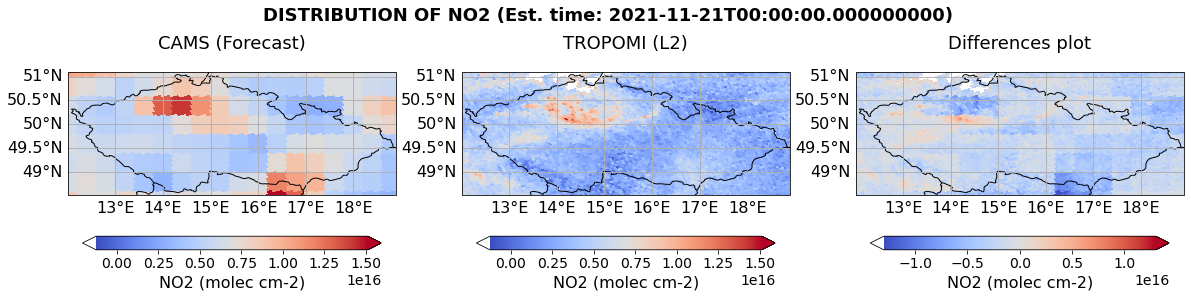

In [21]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'coolwarm' 

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 0.80, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

### Compare CAMS original and averaged total columns

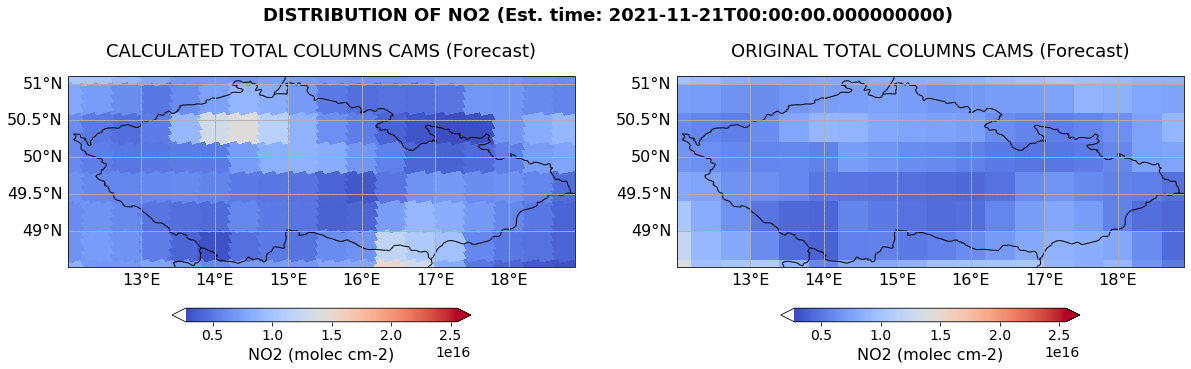

In [22]:
# Choose range (original, equal or manual)
range_type = 'equal' # original or equal
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'coolwarm' 

visualize_model_original_vs_calculated(model, component_nom,units, merge_table, model_total_ds, plot_dates, 
                                       plot_bbox, 20, 1, model_type, range_type, projection, color_scale,
                                       vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

In [23]:
coords_search_list = (50, 60,
                      4, 10,
                      20, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor, model, plot_dates, units)
retrieval_table_all

,,,,,ground_pixel,scanline,model_column,sensor_column,difference
lat_search,lon_search,latitude,longitude,time,,,,,
50,60,48.715141,19.888838,2021-11-21,241.0,110.0,4.000378e+15,1.955150e+15,-2.045228e+15
4,10,46.972500,12.900784,2021-11-21,104.0,110.0,6.975745e+15,1.457204e+15,-5.518541e+15
20,30,48.715141,19.888838,2021-11-21,241.0,110.0,4.000378e+15,1.955150e+15,-2.045228e+15


## 8. Scatter plots by bbox

Fit equation: NO2_model = NO2_sensor * 0.63 + (3.81E+15)
Coefficient of determination (R2): 0.26


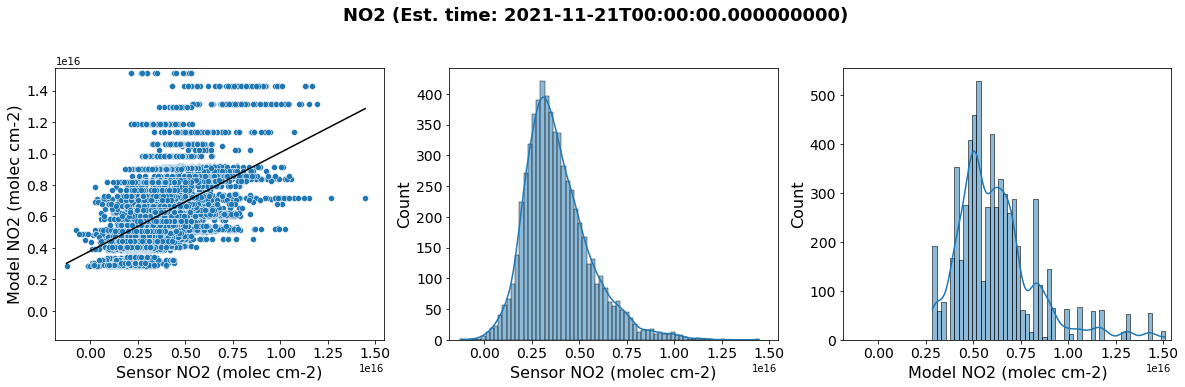

In [47]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [48]:
summary

,Period,Location,Score,Coefficient,Intercept
0,2021-11-21,"((12, 48.5), (18.9, 51.1))",0.263275,0.625288,3.809907e+15


## 9. Scatter plots by season

Fit equation: NO2_model = NO2_sensor * 0.63 + (3.81E+15)
Coefficient of determination (R2): 0.26


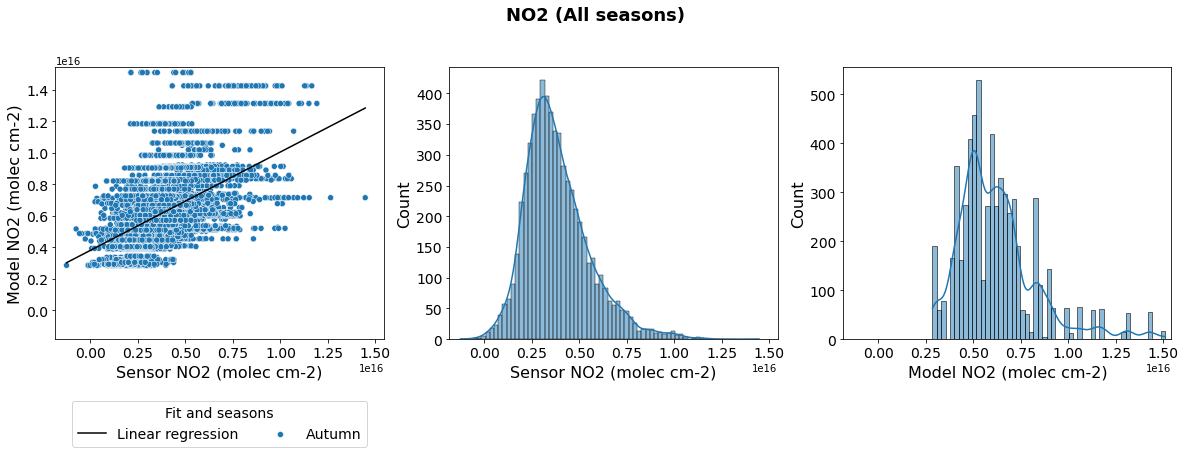

In [49]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [50]:
summary

,Period,Location,Score,Coefficient,Intercept
0,[Autumn],"((12, 48.5), (18.9, 51.1))",0.263275,0.625288,3.809907e+15


## 10. Scatter plots by country (Google API required!)

In [28]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
plot_countries = ['Czech Republic', 'Poland', 'Germany']

lim_min = None
lim_max = None

scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'aggregated' # aggregated or individual\nplot_countries = ['Czech Republic', 'Poland', 'Germany']\n\nlim_min = None\nlim_max = None\n\nscatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, \n             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\n"

In [29]:
#summary